Some part of this code has been adopted from [here.](https://github.com/radioML/examples/blob/master/modulation_recognition/RML2016.10a_VTCNN2_example.ipynb)

In [32]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Reshape, ZeroPadding2D
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
import keras
import keras.models as models
import cPickle
import numpy as np
import scipy
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.cm as cm

import warnings
warnings.simplefilter('ignore')

plt.style.use('ggplot')

## Data Preparation

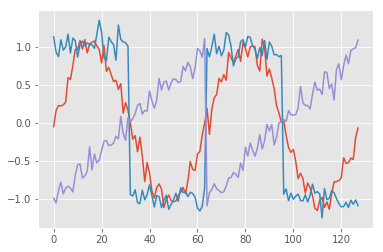

In [33]:
data = cPickle.load(open("dataset.pickle",'rb'))
plt.plot(data[('sin')][4][0])
plt.plot(data[('square')][4][0])
plt.plot(data[('sawtooth')][4][0])

In [34]:
waveforms = [('square'), ('sawtooth'), ('sin')]

X = []  
labels = []
for wave in waveforms:
    X.append(data[(wave)])
    for i in range(data[(wave)].shape[0]):  
        labels.append((wave))

X = np.vstack(X)
X.shape

(300, 1, 128)

In [35]:
np.random.seed(2016)
n_examples = X.shape[0]
n_train = int(n_examples * 0.7)
# Shuffle data
train_idx = np.random.choice(range(0, n_examples), size=n_train, replace=False)
test_idx = list(set(range(0, n_examples)) - set(train_idx))
X_train = X[train_idx]
X_test =  X[test_idx]

def to_onehot(yy):
    yy1 = np.zeros([len(yy), max(yy)+1])
    yy1[np.arange(len(yy)),yy] = 1
    return yy1

Y_train = to_onehot(map(lambda x: waveforms.index(labels[x]), train_idx))
Y_test = to_onehot(map(lambda x: waveforms.index(labels[x]), test_idx))

in_shp = list(X_train.shape[1:]) 
print 'Training Data: ', X_train.shape
print 'Test Data: ', X_test.shape
print 'Input: ', in_shp

classes = waveforms
print 'Waveforms: ', classes

Training Data:  (210, 1, 128)
Test Data:  (90, 1, 128)
Input:  [1, 128]
Waveforms:  ['square', 'sawtooth', 'sin']


## Keras Model

In [38]:
dr = 0.5 # dropout rate 
model = models.Sequential()
model.add(Reshape(in_shp + [1], input_shape=in_shp))
model.add(ZeroPadding2D(padding=(0, 2)))
model.add(Convolution2D(256, 1, 3, border_mode='valid', activation="relu", name="conv1"))
model.add(Dropout(dr))
model.add(ZeroPadding2D((0, 2)))
model.add(Convolution2D(80, 1, 3, border_mode="valid", activation="relu", name="conv2"))
model.add(Dropout(dr))
model.add(Flatten())
model.add(Dense(256, activation='relu', init='he_normal', name="dense1"))
model.add(Dropout(dr))
model.add(Dense( len(classes), init='he_normal', name="dense2" ))
model.add(Activation('softmax'))
model.add(Reshape([len(classes)]))
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
reshape_28 (Reshape)             (None, 1, 128, 1)     0           reshape_input_17[0][0]           
____________________________________________________________________________________________________
zeropadding2d_11 (ZeroPadding2D) (None, 1, 132, 1)     0           reshape_28[0][0]                 
____________________________________________________________________________________________________
conv1 (Convolution2D)            (None, 1, 130, 256)   1024        zeropadding2d_11[0][0]           
____________________________________________________________________________________________________
dropout_31 (Dropout)             (None, 1, 130, 256)   0           conv1[0][0]                      
___________________________________________________________________________________________

In [39]:
# Set up some params 
nb_epoch = 100     # number of epochs to train on
batch_size = 1024  # training batch size

## Model Training

In [40]:
filepath = 'wts.h5'
history = model.fit(X_train,
    Y_train,
    batch_size=batch_size,
    nb_epoch=nb_epoch,
    show_accuracy=False,
    verbose=2,
    validation_data=(X_test, Y_test),
    callbacks = [
        keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
    ])
# we re-load the best weights once training is finished
model.load_weights(filepath)

Train on 210 samples, validate on 90 samples
Epoch 1/100
3s - loss: 1.1287 - val_loss: 0.6352
Epoch 2/100
1s - loss: 0.6780 - val_loss: 0.4113
Epoch 3/100
1s - loss: 0.4150 - val_loss: 0.1558
Epoch 4/100
1s - loss: 0.1899 - val_loss: 0.0684
Epoch 5/100
1s - loss: 0.1070 - val_loss: 0.0273
Epoch 6/100
1s - loss: 0.0370 - val_loss: 0.0181
Epoch 7/100
1s - loss: 0.0277 - val_loss: 0.0149
Epoch 8/100
1s - loss: 0.0137 - val_loss: 0.0150
Epoch 9/100
1s - loss: 0.0105 - val_loss: 0.0159
Epoch 10/100
1s - loss: 0.0098 - val_loss: 0.0170
Epoch 11/100
0s - loss: 0.0088 - val_loss: 0.0184
Epoch 12/100
0s - loss: 0.0096 - val_loss: 0.0199
Epoch 13/100
0s - loss: 0.0087 - val_loss: 0.0215


0.014875867404


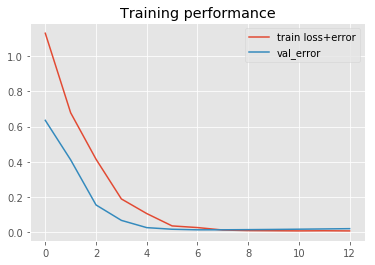

In [41]:
# Performance and Loss curves
score = model.evaluate(X_test, Y_test, show_accuracy=True, verbose=0, batch_size=batch_size)
print score

# Show loss curves 
plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()

## Confusion Matrix

In [42]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

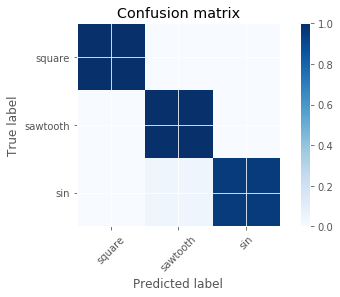

In [43]:
# Plot confusion matrix
test_Y_hat = model.predict(X_test, batch_size=batch_size)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes)